In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [8]:
air_visits = pd.read_csv('./data/visitor_forecasting/air_visit_data.csv')
air_reserve = pd.read_csv('./data/visitor_forecasting/air_reserve.csv')
air_store = pd.read_csv('./data/visitor_forecasting/air_store_info.csv')
holidays = pd.read_csv('./data/visitor_forecasting/date_info.csv')
store_ids = pd.read_csv('./data/visitor_forecasting/store_id_relation.csv')
test = pd.read_csv('./data/visitor_forecasting/sample_submission.csv')

In [9]:
air_visits.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [10]:
air_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [11]:
#Transform visit_date column's datatype to datetime
air_visits['visit_date'] = pd.to_datetime(air_visits['visit_date'], format='%Y-%m-%d')

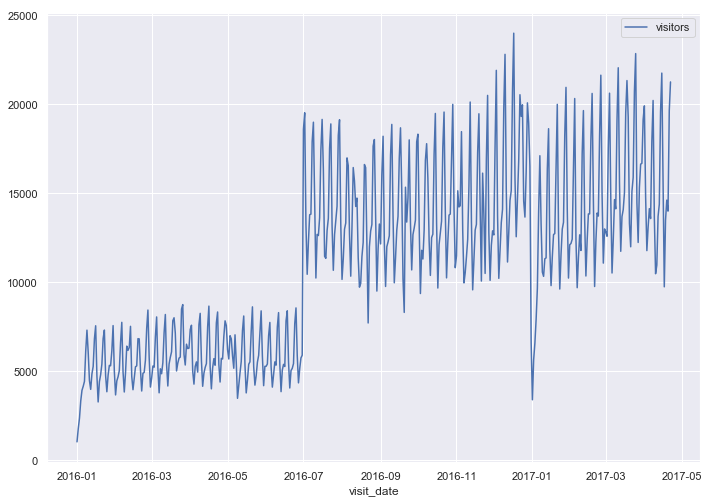

In [12]:
#Plot the total number of visitors per day
N, d = air_visits.shape
visitors_tot = air_visits.groupby(['visit_date']).sum()
sns.lineplot(data=visitors_tot)

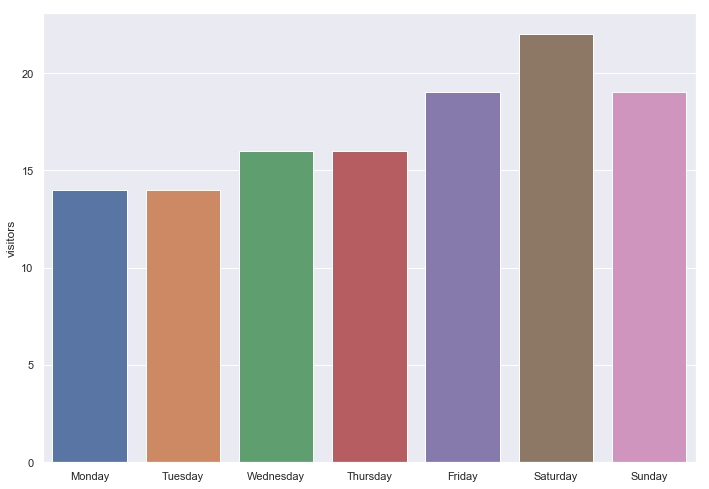

In [13]:
#Perhaps new restaurants have been added to the database at around July of 2016
#Clear periodic pattern, weekly cycle?

#Plot the median of visitors for every weekday
air_visits['Day of week'] = air_visits['visit_date'].dt.day_name()
visitors_by_weekday = air_visits.groupby(['Day of week']).median()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
visitors_by_weekday = visitors_by_weekday.reindex(order)
sns.barplot(x=order, y=visitors_by_weekday['visitors'])

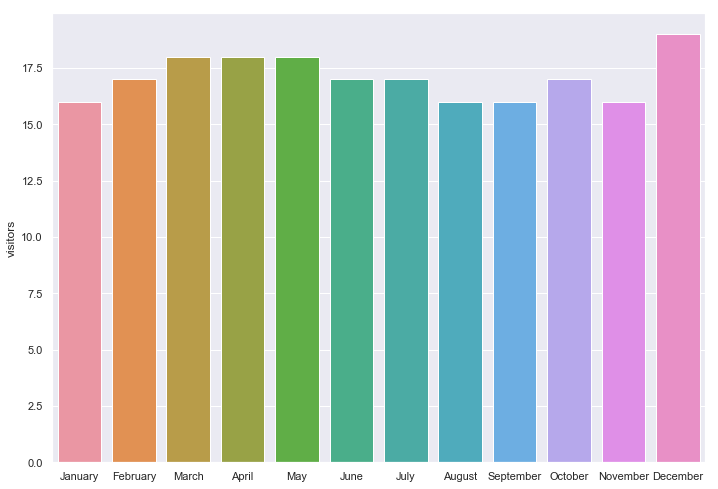

In [14]:
#How does the amount of visitors depend on the month?
#Plot the medians of visitors for every month
air_visits['Month'] = air_visits['visit_date'].dt.month_name()
visitors_by_month = air_visits.groupby(['Month']).median()
visitors_by_month.head()
order_m = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
visitors_by_month = visitors_by_month.reindex(order_m)
sns.barplot(x=order_m, y=visitors_by_month['visitors'])

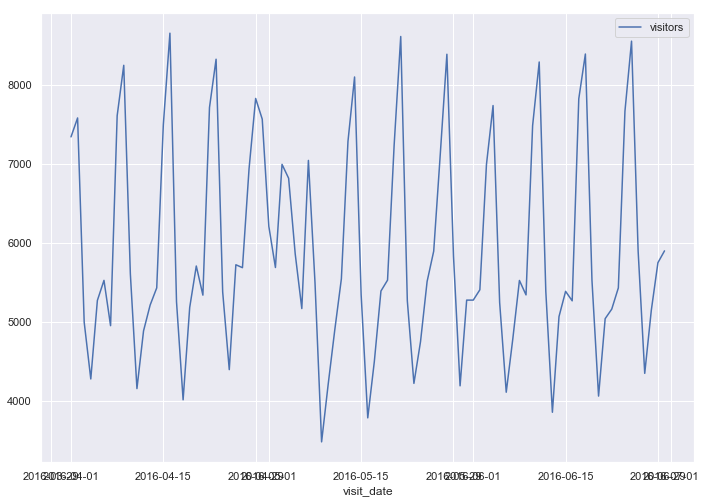

In [15]:
#The forecasting is done for the last week of April and May 2017
#A closer look at the total visitors in that period in the previous year
pred_period_prev_year = visitors_tot.loc['2016-04-01':'2016-06-30']
sns.lineplot(data=pred_period_prev_year)

In [16]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [17]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [18]:
#Transform the column types
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'], format='%Y-%m-%d %H:%M:%S')
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'], format='%Y-%m-%d %H:%M:%S')

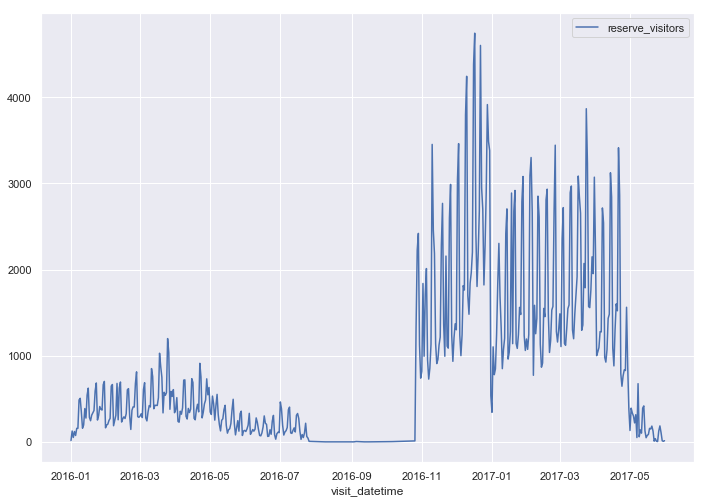

In [19]:
#What is the visitor volume through reservations?
visitors_tot_r = air_reserve.groupby(air_reserve['visit_datetime'].dt.date).sum()
sns.lineplot(data=visitors_tot_r)

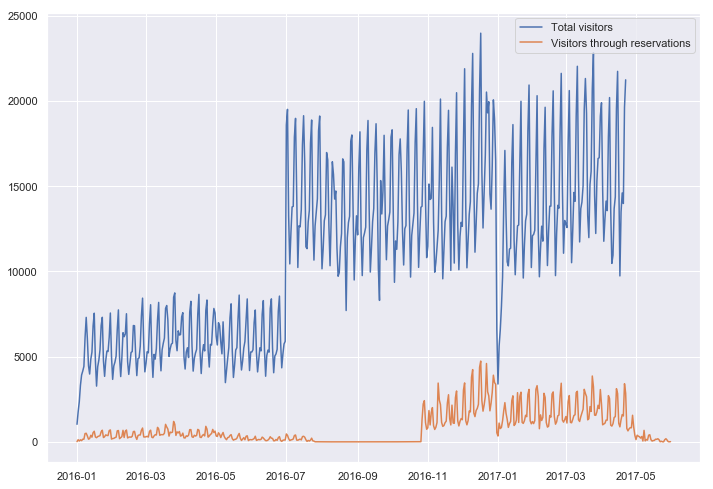

In [20]:
#How does the amount of visitors through reservations compare to the total amount of visitors?
plt.plot(visitors_tot, label='Total visitors')
plt.plot(visitors_tot_r, label='Visitors through reservations')
plt.legend()
plt.show()

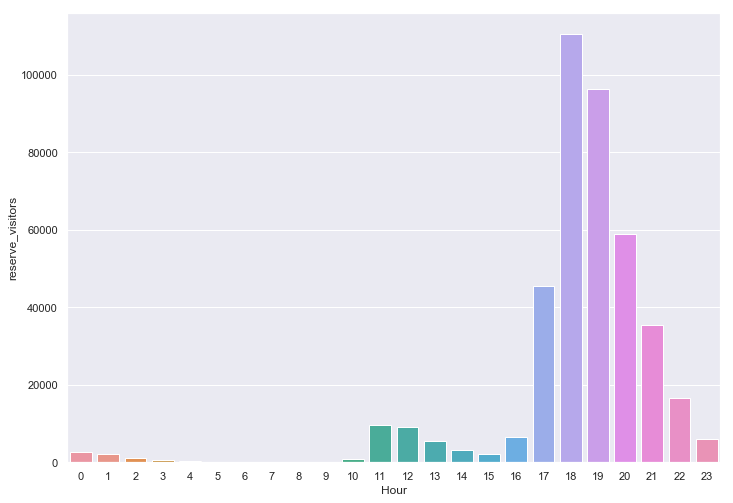

In [21]:
#For which hour are the reservations usually made?
air_reserve['Hour'] = air_reserve['visit_datetime'].dt.hour
visit_hours_r = air_reserve.groupby(['Hour']).sum()
sns.barplot(x=visit_hours_r.index, y=visit_hours_r.reserve_visitors)

C:\Users\Otto-Ville\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


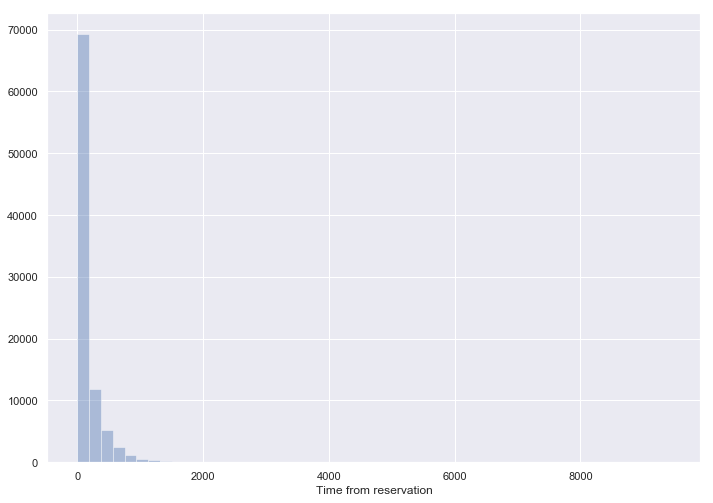

In [22]:
#How early in advance are the reservations made?
air_reserve['Time from reservation'] = (air_reserve['visit_datetime'] - air_reserve['reserve_datetime']).astype('timedelta64[h]')
ax = sns.distplot(air_reserve['Time from reservation'], kde=False)

C:\Users\Otto-Ville\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


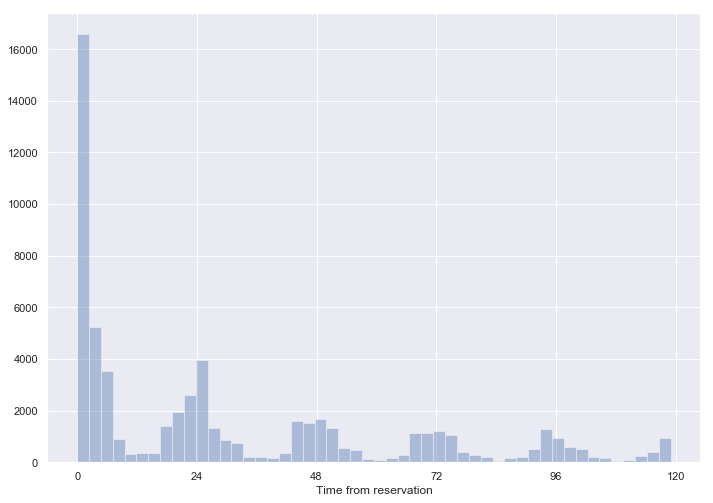

In [23]:
#A more informative histogram
s = air_reserve['Time from reservation']
s = s[s < 5 * 24]
ax = sns.distplot(s, kde=False)
ax.set_xticks([0, 24, 48, 72, 96, 120])
plt.show()

In [24]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [25]:
air_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


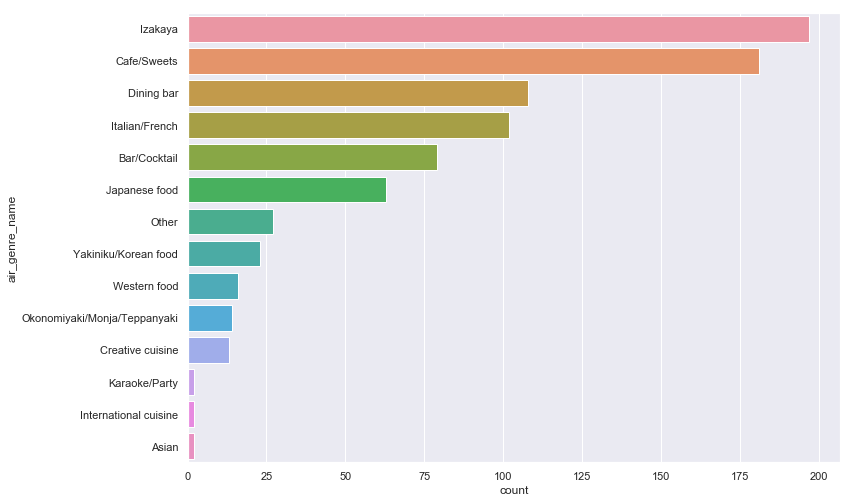

In [26]:
#How are the the different genres represented?
sns.countplot(y="air_genre_name", data=air_store, order = air_store['air_genre_name'].value_counts().index)

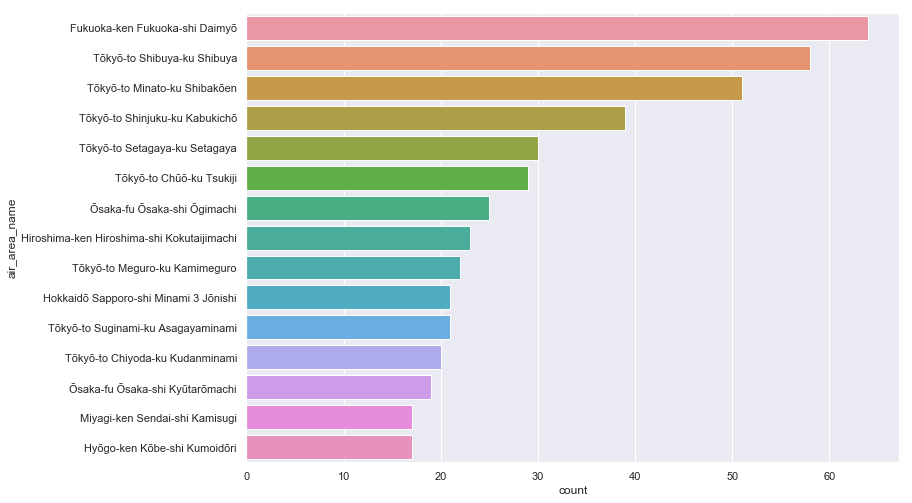

In [27]:
#What are the top 15 areas?
sns.countplot(y="air_area_name", data=air_store, order = air_store['air_area_name'].value_counts().iloc[:15].index)

In [28]:
#How are the visitors divided by the genre?
air_visits_store = pd.merge(air_visits, air_store[['air_genre_name', 'air_store_id']], on='air_store_id')
air_visits_store.head()

,air_store_id,visit_date,visitors,Day of week,Month,air_genre_name
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,January,Dining bar
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,January,Dining bar
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,January,Dining bar
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,January,Dining bar
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,January,Dining bar


In [29]:
visitor_means_by_date_and_genre = air_visits_store.groupby(['visit_date', 'air_genre_name']).mean()
visitor_means_by_date_and_genre.reset_index(inplace=True)

visitor_means_by_date_and_genre.head()

,visit_date,air_genre_name,visitors
0,2016-01-01,Bar/Cocktail,15.111111
1,2016-01-01,Cafe/Sweets,26.600000
2,2016-01-01,Creative cuisine,7.000000
3,2016-01-01,Dining bar,15.142857
4,2016-01-01,Italian/French,5.750000


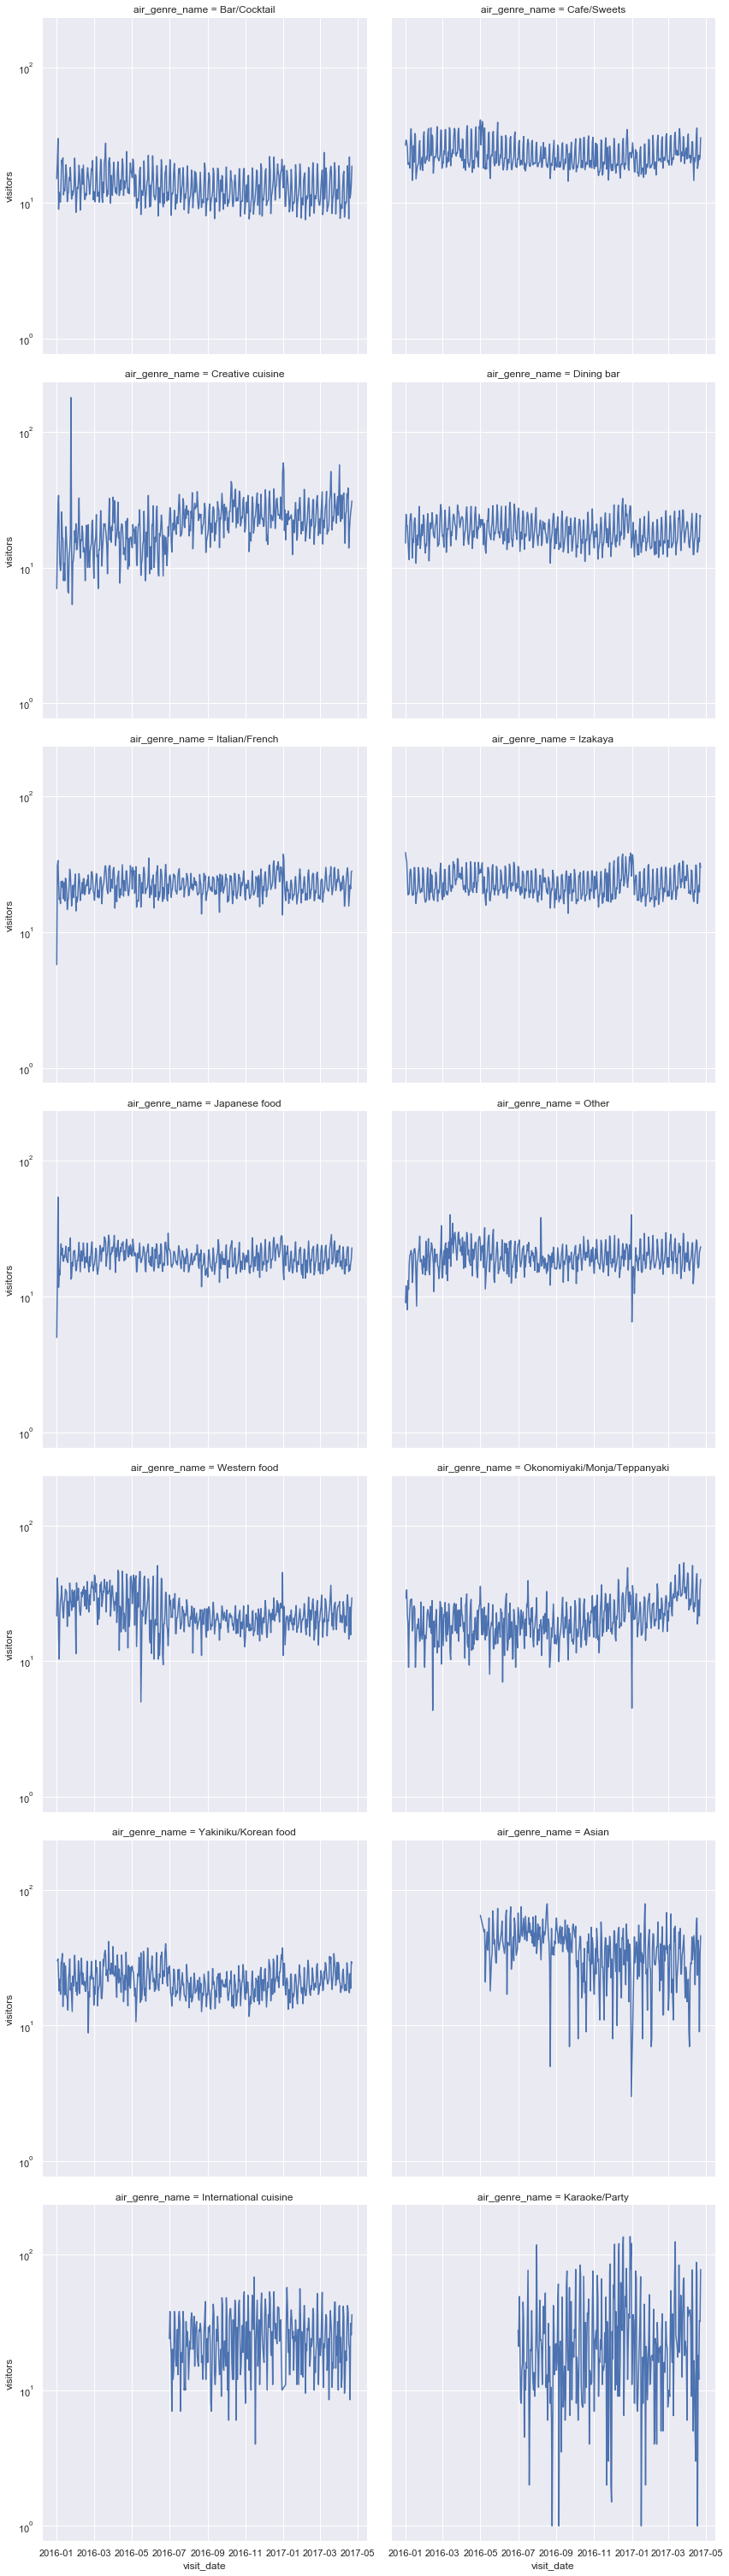

In [41]:
g = sns.FacetGrid(visitor_means_by_date_and_genre, col="air_genre_name", col_wrap=2, height=6)
g.map(sns.lineplot, "visit_date", "visitors", ci=None);
g.fig.get_axes()[0].set_yscale('log')